# MATH7013 Project
## [*Deep Direct RL for Financial Signal Representation and Training*](http://cslt.riit.tsinghua.edu.cn/mediawiki/images/a/aa/07407387.pdf) - paper by Deng et al.
## Program for training and testing the FDRNN
### Implemented by Joel Thomas

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import torch
import timeit

pd.options.mode.chained_assignment = None
# Set font size when plotting
plt.rcParams.update({'font.size': 14})

### Check if GPU is available for training the FDRNN, quit program otherwise

In [2]:
if torch.cuda.is_available():
    device = torch.cuda.current_device()
    print(f"NVIDIA CUDA GPU available: {torch.cuda.get_device_name(device)}")

NVIDIA CUDA GPU available: NVIDIA GeForce RTX 3060 Ti


### Load in a preprocessed dataset

In [3]:
df = pd.read_csv("../Data Preprocessing/SPXUSD_2017.csv", index_col="date")
df.drop("p_t", axis=1, inplace=True)
# Convert date column to datetime type
df.index = pd.to_datetime(df.index)
df.head()

,z_t,z_(t-1),z_(t-2),z_(t-3),z_(t-4),z_(t-5),z_(t-6),z_(t-7),z_(t-8),z_(t-9),...,z_(t-40),z_(t-41),z_(t-42),z_(t-43),z_(t-44),m_(t-180),m_(t-300),m_(t-1440),m_(t-4320),m_(t-14400)
date,,,,,,,,,,,,,,,,,,,,,
2017-01-17 10:00:00,0.00,-0.75,0.00,0.25,0.25,0.00,0.25,1.00,-0.25,-0.75,...,0.50,0.0,0.0,0.25,-0.75,0.25,-1.25,-6.00,-2.75,17.75
2017-01-17 10:01:00,-1.00,0.00,-0.75,0.00,0.25,0.25,0.00,0.25,1.00,-0.25,...,-0.50,0.5,0.0,0.00,0.25,-0.50,-2.25,-7.00,-3.75,17.25
2017-01-17 10:02:00,0.50,-1.00,0.00,-0.75,0.00,0.25,0.25,0.00,0.25,1.00,...,0.00,-0.5,0.5,0.00,0.00,-0.50,-2.00,-6.25,-3.25,17.50
2017-01-17 10:03:00,0.50,0.50,-1.00,0.00,-0.75,0.00,0.25,0.25,0.00,0.25,...,0.00,0.0,-0.5,0.50,0.00,-0.50,-1.50,-6.00,-2.75,18.25
2017-01-17 10:04:00,0.25,0.50,0.50,-1.00,0.00,-0.75,0.00,0.25,0.25,0.00,...,-0.75,0.0,0.0,-0.50,0.50,-1.75,-1.50,-5.75,-2.50,17.75


### Set important parameters

In [4]:
# Transaction cost to use for training and testing
c = 15

# Number of training samples
num_train = len(df)//3

# Training set
train_df = df.iloc[:num_train]

# Testing set
test_df = df.iloc[num_train:]

# Number of training iterations
num_epochs = 100

# Dimension of each feature vector f_t
input_size = len(df.columns)

# Number of clusters in k-means clustering (fuzzy degrees)
k = 3

### Set important hyperparameters

In [5]:
# Number of training samples in each batch
batch_size = 32

# Number of time steps to feed into FDRNN at a time
seq_length = 3

# Input and output size to each hidden layer in the ANN component
fc_hidden_size = 128

# Number of fully-connected hidden layers in the ANN component
num_fc = 4

# Size of each output F_t after passing through fuzzy and deep representations
output_size = 20

# Number of features in a hidden state for the RNN component (shape of delta_t)
rec_hidden_size = 1

# Number of (stacked) recurrent layers
num_rec = 1

# Learning rate to be used during training
eta = 0.00001

# Weight decay (L2 regularisation penalty) to be used during training
lambda_ = 0.000001

### Use k-means clustering to store each fuzzy node's mean and width to be used later (i.e. fuzzy layer initialisation)

In [6]:
kmeans = KMeans(n_clusters=k).fit(train_df)

# Get cluster labels for samples and make a new column
train_df["label"] = kmeans.labels_
train_df.head()

,z_t,z_(t-1),z_(t-2),z_(t-3),z_(t-4),z_(t-5),z_(t-6),z_(t-7),z_(t-8),z_(t-9),...,z_(t-41),z_(t-42),z_(t-43),z_(t-44),m_(t-180),m_(t-300),m_(t-1440),m_(t-4320),m_(t-14400),label
date,,,,,,,,,,,,,,,,,,,,,
2017-01-17 10:00:00,0.00,-0.75,0.00,0.25,0.25,0.00,0.25,1.00,-0.25,-0.75,...,0.0,0.0,0.25,-0.75,0.25,-1.25,-6.00,-2.75,17.75,1
2017-01-17 10:01:00,-1.00,0.00,-0.75,0.00,0.25,0.25,0.00,0.25,1.00,-0.25,...,0.5,0.0,0.00,0.25,-0.50,-2.25,-7.00,-3.75,17.25,1
2017-01-17 10:02:00,0.50,-1.00,0.00,-0.75,0.00,0.25,0.25,0.00,0.25,1.00,...,-0.5,0.5,0.00,0.00,-0.50,-2.00,-6.25,-3.25,17.50,1
2017-01-17 10:03:00,0.50,0.50,-1.00,0.00,-0.75,0.00,0.25,0.25,0.00,0.25,...,0.0,-0.5,0.50,0.00,-0.50,-1.50,-6.00,-2.75,18.25,1
2017-01-17 10:04:00,0.25,0.50,0.50,-1.00,0.00,-0.75,0.00,0.25,0.25,0.00,...,0.0,0.0,-0.50,0.50,-1.75,-1.50,-5.75,-2.50,17.75,1


In [7]:
# Stores means and widths required for fuzzy layer initialisation
fuzzy_params = []
# Calculate the mean and variance of each dimension (feature) in each cluster using all training samples
for label in range(k):
    for column in train_df.columns[:-1]:
        feat_given_k = train_df[train_df["label"] == label][column]
        fuzzy_params.append([feat_given_k.mean(), feat_given_k.var()])

train_df.drop("label", axis=1, inplace=True)
# Will always be of shape (input_size*k, 2)
fuzzy_params = np.array(fuzzy_params, dtype=np.float32)
print(fuzzy_params.shape)

(150, 2)


### Class for fuzzy layer

In [8]:
class FuzzyLayer(torch.nn.Module):
    """
    Custom PyTorch neural network module that implements a single fuzzy layer used as the second layer in the FDRNN.
    """
    def __init__(self, input_size, fuzzy_deg, fuzzy_params, batch_size, seq_length):
        """
        Initialises the fuzzy layer with important parameters.
        """
        super(FuzzyLayer, self).__init__()
        self.input_size = input_size                        # Size of each input f_t
        self.fuzzy_deg = fuzzy_deg                          # Number of fuzzy degrees to assign to each dimension of f_t
        self.fuzzy_params = fuzzy_params                    # 2D Matrix of means and widths of each node in the fuzzy layer 
        self.batch_size = batch_size                        # Number of total inputs in a single batch fed into the FDRNN
        self.seq_length = seq_length                        # Number of consecutive timesteps (f_ts) considered in one input
        self.output_size = self.input_size*self.fuzzy_deg   # Size of each output after passing f_t through fuzzy layer
    
    def forward(self, x):
        """
        Perform a forward pass of input x (batch containing multiple sequences of f_ts) through the fuzzy layer and return
        the fuzzied output for each f_t in each sequence in the given batch.
        """
        # Stores fuzzied x
        fuzzied_x = []
        for seq in x:
            # Stores fuzzied (sequence of) f_ts
            fuzzied_seq = []
            for f_t in seq:
                # Stores fuzzied f_t
                fuzzied_f_t = []
                for k in range(self.fuzzy_deg):
                    curr_idx = k*self.input_size
                    next_idx = (k + 1)*self.input_size
                    # Use Gaussian membership function in generating fuzzied representation of each provided f_t
                    fuzzied_f_t.append(np.exp(-1*np.divide(np.square(f_t - self.fuzzy_params[curr_idx:next_idx, 0]),
                                                           self.fuzzy_params[curr_idx:next_idx, 1])))
                
                fuzzied_seq.append(fuzzied_f_t)
            
            fuzzied_x.append(fuzzied_seq)
        
        fuzzied_x = np.reshape(np.array(fuzzied_x, dtype=np.float32), (self.batch_size, self.seq_length, self.output_size))
        # Store on device memory to help train model on GPU
        x = torch.cuda.FloatTensor(fuzzied_x)
        return x
    
    def extra_repr(self):
        """
        Use when printing information about an initialised fuzzy layer.
        """
        return f"in_features={self.input_size}, out_features={self.output_size}"

### Class for FDRNN model

In [9]:
class FDRNN(torch.nn.Module):
    def __init__(self, input_size, fuzzy_deg, fuzzy_params, batch_size, seq_length, fc_hidden_size, num_fc, output_size,
                 rec_hidden_size, num_rec):
        """
        Initialises the FDRNN with important parameters.
        """
        super(FDRNN, self).__init__()
        self.input_size = input_size            # Size of each input f_t
        self.batch_size = batch_size            # Number of total inputs in a single batch fed into the FDRNN
        self.seq_length = seq_length            # Number of consecutive timesteps (f_ts) considered in one input
        self.fc_hidden_size = fc_hidden_size    # Number of hidden cells in each fully-connected (dense/linear) layer
        self.num_fc = num_fc                    # Number of fully-connected layers
        self.output_size = output_size          # Size of each output F_t after passing through fuzzy and all deep layers
        self.rec_hidden_size = rec_hidden_size  # Number of features in a hidden state for the RNN
        self.num_rec = num_rec                  # Number of (stacked) recurrent layers
        
        # Fuzzy layer
        self.fuzzy = FuzzyLayer(self.input_size, fuzzy_deg, fuzzy_params, self.batch_size, self.seq_length)
        
        # Fully-connected layers (deep transformations)
        self.fcs = torch.nn.ModuleList([torch.nn.Linear(self.fuzzy.output_size, self.fc_hidden_size)])
        self.fcs.extend([torch.nn.Linear(self.fc_hidden_size, self.fc_hidden_size) for i in range(self.num_fc - 2)])
        self.fcs.append(torch.nn.Linear(self.fc_hidden_size, self.output_size))
        
        # RNN layer (to calculate delta_t for each f_t for each sequence in given batch)
        self.rnn = torch.nn.RNN(self.output_size, self.rec_hidden_size, self.num_rec, nonlinearity='tanh', bias=True,
                                batch_first=True)
    
    def forward(self, x):
        """
        Perform a forward pass of input x (batch containing multiple sequences of f_ts) through the fuzzy, fully-connected and
        RNN layer and returns delta_t for each f_t in each sequence in the given batch.
        """
        x = self.fuzzy.forward(x)
        for fc in self.fcs:
            x = fc(x)
        # Next line is equivalent to delta_t, h = self.rnn(x)
        x, h = self.rnn(x)
        # Flatten from (batch_size, seq_length, rec_hidden_size)-shape tensor to 1D tensor
        # x = torch.flatten(x)
        return x

###  Batch generator for generating batches and profit function to be used during training and testing the FDRNN

In [10]:
def make_batch_generator(df, batch_size, seq_length):
    """
    Creates a batch generator that yields a single batch and corresponding sequence of z_ts whenever a call to the
    resulting generator object is made. Generated batches are used as raw input to the FDRNN during training and testing.
    The corresponding sequence of z_ts is used to help calculate the resulting loss after a forward pass has been made.
    """
    for i in range(0, len(df) - batch_size, batch_size):
        batch = []
        z_ts = []
        for j in range(batch_size):
            seq = df.iloc[i+j:i+j+seq_length].values
            batch.append(seq)
            z_t = df["z_t"].iloc[i+j+seq_length-1]
            z_ts.append(z_t)
        
        batch = np.reshape(np.array(batch), (batch_size, seq_length, input_size))
        z_ts = torch.reshape(torch.tensor(z_ts), (batch_size, 1)).to(device)
        yield (batch, z_ts)

### Function to calculate U_t

In [11]:
def calc_U_t(delta_ts, z_ts, c, pnl_over_time):
    """
    Calculate (a slice) of U_t based on the forward pass output of a single batch fed into the FDRNN. The loss function for
    the FDRNN is given by the negative of this function and hence, this function can be used to calculate the loss on the
    output of a single batch fed into the FDRNN. Each loss is used to update the parameters belonging to the fully-connected
    layers and RNN layer via regular backpropagation and backpropagation through time (BPTT) respectively. The fuzzy layer is
    excluded since it does not contain any parameters (recall used k-means to finalise the means and widths of the fuzzy nodes).
    """
    # Short way - use this for calculating gradients and updating 
    U_t = torch.sum(torch.mul(delta_ts[:, -2], z_ts) - c*torch.abs(delta_ts[:, -1] - delta_ts[:, -2]))
    # Long way - use this for plotting accumulated rewards R_ts (i.e. true U_T) over time
    if pnl_over_time != []:
        for i in range(delta_ts.shape[0]):
            pnl_over_time.append(pnl_over_time[-1] + delta_ts[i, -2].item()*z_ts[i].item() -
                                 c*abs(delta_ts[i, -1].item() - delta_ts[i, -2].item()))
    # Return U_t since loss = -1*U_t and use loss.backward() for updating all gradients
    return U_t

### Training the FDRNN model

In [12]:
# Initialise FDRNN model on GPU
fdrnn = FDRNN(input_size, k, fuzzy_params, batch_size, seq_length, fc_hidden_size, num_fc, output_size,
              rec_hidden_size, num_rec).cuda()

# Initialise SGD optimiser with specified learning rate and L2 penalty
optimiser = torch.optim.SGD(fdrnn.parameters(), lr=eta, weight_decay=lambda_)

In [13]:
# Begin training the FDRNN model
print("Beginning FDRNN training...")
start_time = timeit.default_timer()

epoch_losses = []
for epoch in range(1, num_epochs + 1):
    print(f"Epoch: {epoch}")
    batch_generator = make_batch_generator(train_df, batch_size, seq_length)
    epoch_loss = 0
    if epoch == num_epochs:
        pnl_over_time = [0]
    for batch, z_ts in batch_generator:
        optimiser.zero_grad()
        delta_ts = fdrnn(batch)
        # Minimising loss here is equivalent to maximising total accumulated rewards
        if epoch == num_epochs:
            loss = -1*calc_U_t(delta_ts, z_ts, c, pnl_over_time)
        else:
            loss = -1*calc_U_t(delta_ts, z_ts, c, [])
        loss.backward()
        optimiser.step()
        epoch_loss += loss.item()
        
    epoch_losses.append(epoch_loss)

# Save training loss function
# np.save(f"SPXUSD_2017_epoch_losses.npy", np.array(epoch_losses, dtype=np.float32))
# Save training profit and loss over time
# np.save(f"SPXUSD_2017_train_pnl_over_time.npy", np.array(pnl_over_time, dtype=np.float32))
end_time = timeit.default_timer()
print(f"Total training time: {end_time - start_time}s")

Beginning FDRNN training...
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
E

### Plot training loss function

Text(0.5, 1.0, 'SPXUSD: Training Loss/Epoch based on First 4 Months of 2017')

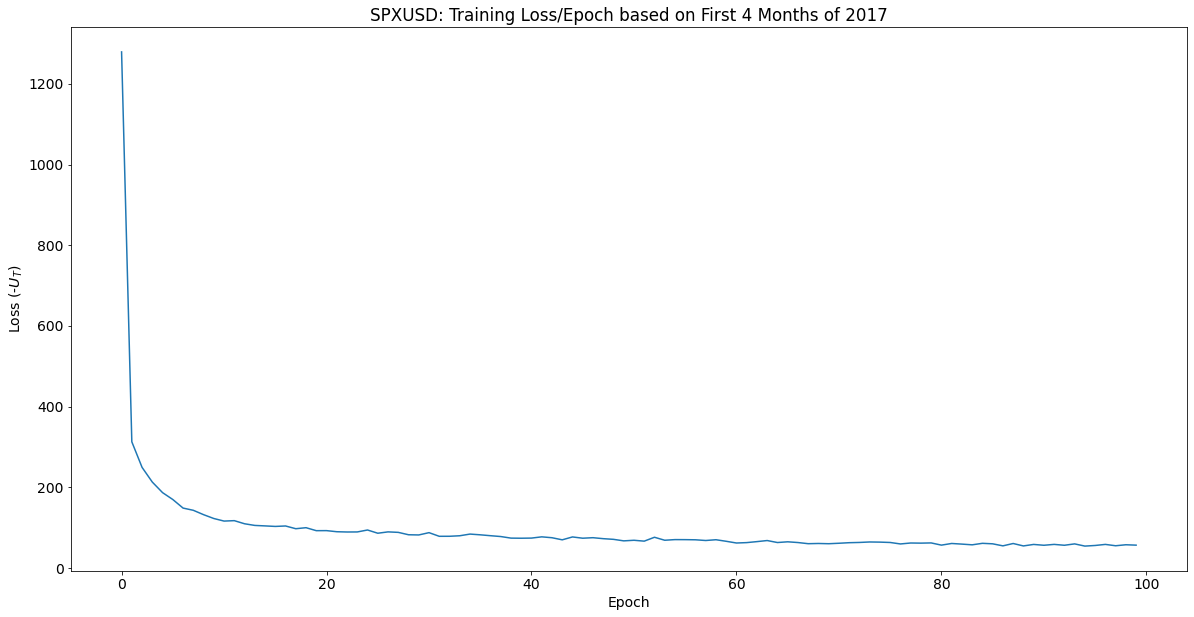

In [14]:
plt.figure(figsize=(20, 10))
plt.plot(range(num_epochs), epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss (-$U_T$)")
plt.title("SPXUSD: Training Loss/Epoch based on First 4 Months of 2017")
# plt.savefig("SPXUSD_2017_loss.png", facecolor="w")

### Plot accumulated profits over training period using trained model after final epoch

Text(0.5, 1.0, 'SPXUSD: Accumulated Rewards for First 4 Months of 2017')

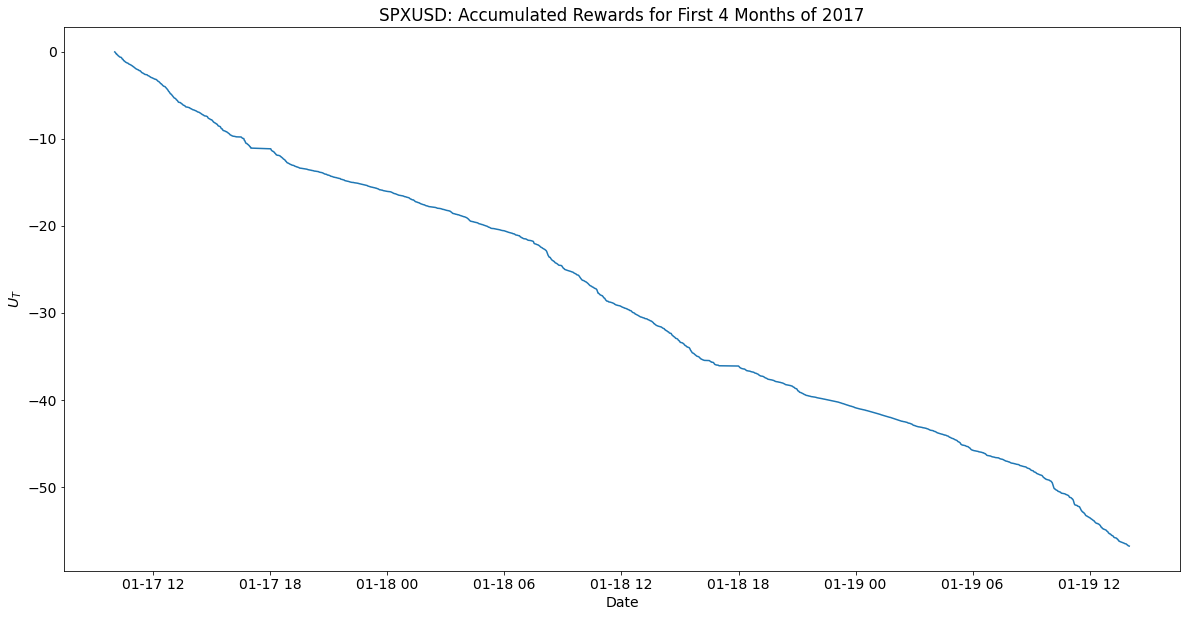

In [15]:
plt.figure(figsize=(20, 10))
plt.plot(train_df.index[seq_length-2:len(pnl_over_time)], pnl_over_time[1:])
plt.xlabel("Date")
plt.ylabel("$U_T$")
plt.title("SPXUSD: Accumulated Rewards for First 4 Months of 2017")
# plt.savefig("SPXUSD_2017_train.png", facecolor="w")

### Save the trained FDRNN model

In [16]:
# Save model's parameters (weights, biases, etc.)
# torch.save(fdrnn.state_dict(), "SPXUSD_2017.pt")

### Testing the FDRNN model

In [17]:
# Begin testing the FDRNN model
print("Beginning FDRNN testing...")
start_time = timeit.default_timer()

batch_generator = make_batch_generator(test_df, batch_size, seq_length)
pnl_over_time = [0]
with torch.no_grad():
    for batch, z_ts in batch_generator:
        delta_ts = fdrnn(batch)
        calc_U_t(delta_ts, z_ts, c, pnl_over_time)

# Save testing profit and loss over time
# np.save(f"SPXUSD_2017_test_pnl_over_time.npy", np.array(pnl_over_time, dtype=np.float32))
end_time = timeit.default_timer()
print(f"Total testing time: {end_time - start_time}s")

Beginning FDRNN testing...
Total testing time: 74.82457769999999s


### Plot accumulated profits over testing period

Text(0.5, 1.0, 'SPXUSD: Accumulated Rewards for Last 8 Months of 2017')

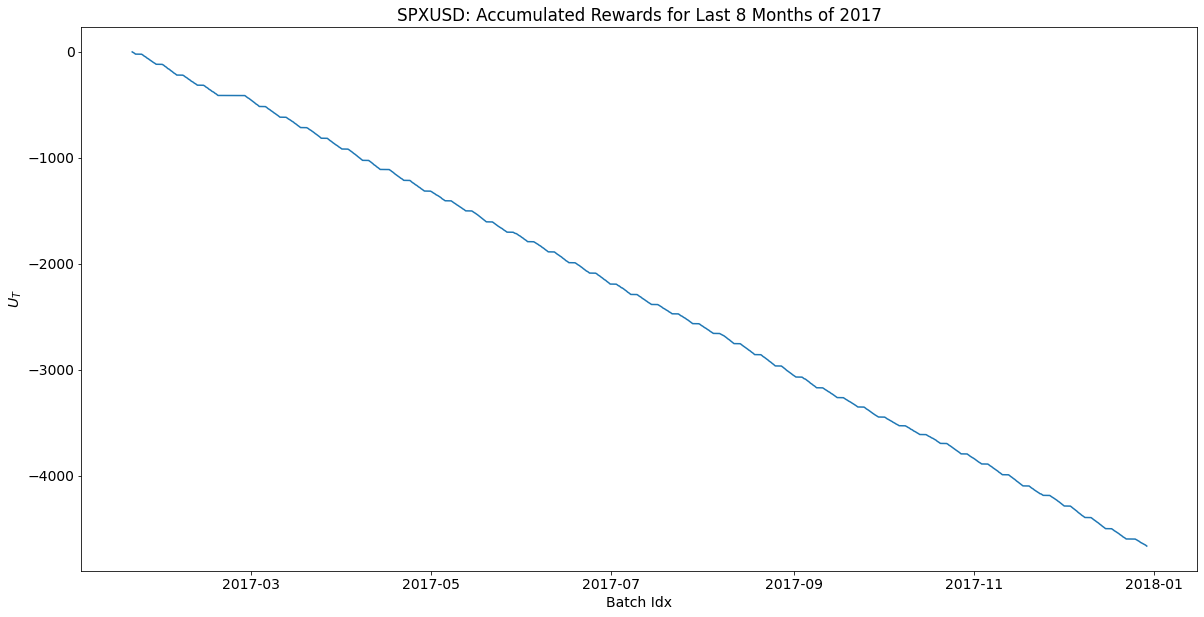

In [18]:
plt.figure(figsize=(20, 10))
plt.plot(test_df.index[seq_length-2:len(pnl_over_time)], pnl_over_time[1:])
plt.xlabel("Batch Idx")
plt.ylabel("$U_T$")
plt.title("SPXUSD: Accumulated Rewards for Last 8 Months of 2017")
# plt.savefig("SPXUSD_2017_test.png", facecolor="w")